# Electric Potential

## Mathematical description

In this notebook, we will explore the electric potential of a arbitray charge distribution. To do this, we will solve **numerically** the Laplace equation for the electric potential $V$.

$$ \nabla^2 V = 0 $$

We're going to star with a square 2D, so everywhere in the square. Then the Laplace equation becomes

$$ \frac{\partial^2 V}{\partial x^2} + \frac{\partial^2 V}{\partial y^2} = 0 $$

We can discretize this equation rewriting it as:

$$\frac{V(x_{i+1}, y_j) - 2V(x_i, y_j) + V(x_{i-1}, y_j)}{(\Delta x)^2} + \frac{V(x_i, y_{j+1}) - 2V(x_i, y_j) + V(x_i, y_{j-1})}{(\Delta y)^2} = 0$$

but, here we note that $\Delta x = \Delta y$, so we can solve $V(x_i, y_j)$ as

$$V(x_i, y_j) = \frac{1}{4} \left[V(x_{i+1}, y_j) + V(x_{i-1}, y_j) + V(x_i, y_{j+1}) + V(x_i, y_{j-1})\right]$$

we see that it means that a certain point is the average of the four points around it. So we start with the boundary conditions and then we iterate until we reach a certain tolerance.

We will use the following boundary conditions:

$$\begin{align*}
V(x, 1) &= \cos(\pi x/2)\\
V(x, 0) &= x^4\\
V(0, y) &= \frac{1}{(e^{-1}-e) }(e^y - e)\\
V(1, y) &= \frac{1}{2} (y^2 - y)
\end{align*}
$$


## Python implementation

### Libraries

We will use the following libraries:
* `numpy` for the numerical calculations
* `matplotlib` for the plots
* `skimage` for the image processing
* `numba` for the just-in-time compilation

In [1]:
%pip install numpy matplotlib scikit-image numba --quiet

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import PillowWriter
from matplotlib import cm
from skimage import io
from skimage import color
import numba
from numba import jit

### Boundary conditions

Define the boundary conditions:

In [3]:
edge = np.linspace(-2, 2, 300)
upper_y = np.cos(np.pi * edge / 2)
lower_y = edge**4
upper_x = 1 /( np.e**(-1) - np.e ) * ( np.exp(edge) - np.e )
lower_x = 0.5 * (edge**2 - edge)

Get a meshgrid of the points:

In [4]:
xv, yv = np.meshgrid(edge, edge)

Define a function to solve for the potential:

In [5]:
@jit("f8[:,:](f8[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length -1):
            for j in range(1, length -1):
                potential[i][j] = (potential[i+1][j] + potential[i-1][j] + potential[i][j+1] + potential[i][j-1]) / 4

    return potential

Solve the potential:

In [6]:
potential = np.zeros((len(edge), len(edge)))
potential[0, :] = lower_y
potential[-1, :] = upper_y
potential[:, 0] = lower_x
potential[:, -1] = upper_x
potential = compute_potential(potential, 30_000)

We can plot the potential:

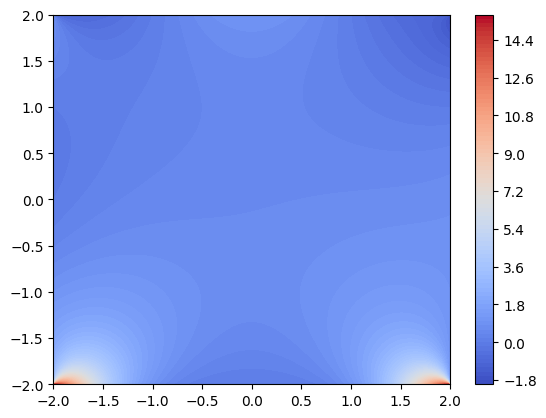

In [7]:
plt.contourf(xv, yv, potential, 100, cmap="coolwarm")
plt.colorbar()
plt.show()

### With a Block of Fixed Potential

Define a block which is set a constant potential: $V = 1$:

In [8]:
def potential_block(x, y):
    return np.select([(x > 0.5) * (x < 0.7) * (y > 0.5) * (y < 0.7), 
                      (x <= 0.5) + (x >= 0.5) + (y <= 0.5) + (y >= 0.7)], 
                      [1, 0])

We can plot the potential:

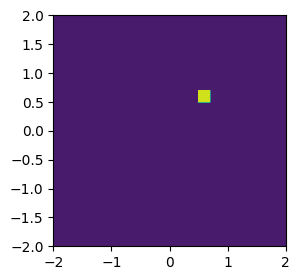

In [9]:
plt.figure(figsize=(3, 3))
plt.contourf(xv, yv, potential_block(xv, yv))

Obtain the fixed potential, and the places where the potential is fixed:

In [10]:
fixed = potential_block(xv, yv)
fixed_bool = fixed != 0

Modify the function to solve for the potential:

In [11]:
@jit("f8[:,:](f8[:,:], b1[:,:], i8)", nopython=True, nogil=True)
def compute_potential(potential,fixed_bool, n_iter):
    length = len(potential[0])
    for n in range(n_iter):
        for i in range(1, length -1):
            for j in range(1, length -1):
                if not fixed_bool[i][j]:
                    potential[i][j] = (potential[i+1][j] + potential[i-1][j] + potential[i][j+1] + potential[i][j-1]) / 4

    return potential

Solve the potential:

In [12]:
potential = np.zeros((len(edge), len(edge)))
potential[0, :] = lower_y
potential[-1, :] = upper_y
potential[:, 0] = lower_x
potential[:, -1] = upper_x
potential[fixed_bool] = fixed[fixed_bool]
potential = compute_potential(potential, fixed_bool, 1_000_000)

Plot the potential:

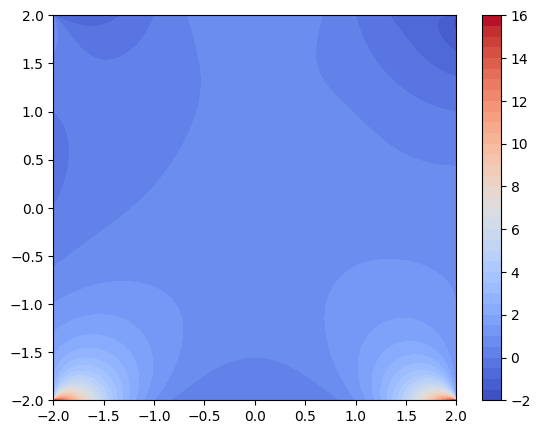

In [13]:
plt.figure(figsize=(6.5,5))
plt.contourf(xv, yv, potential, 40, cmap="coolwarm")
plt.colorbar()
plt.show()

With that, we can also plot the electric field, remembering that the electric field is given by

$$\vec{E} = -\nabla V$$

In [14]:
E_x, E_y = np.gradient(-potential)
E = np.sqrt(E_x**2 + E_y**2)

Plot the electric field:

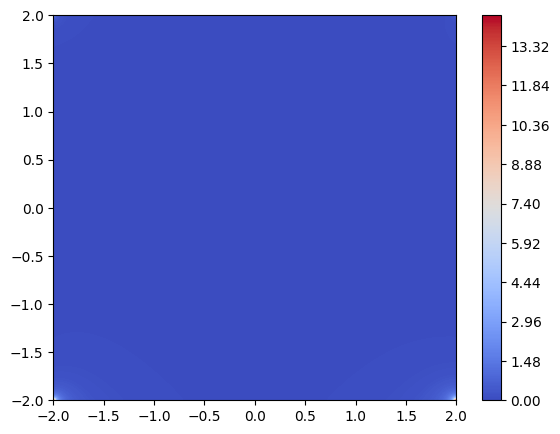

In [15]:
plt.figure(figsize=(6.5,5))
plt.contourf(xv, yv, E, 400, cmap="coolwarm")
plt.colorbar()
plt.show()